# Pre-processing of GLAMOS MB data:

Does the pre-processing of the point MB measurements from GLAMOS (winter and summer).

# Point Mass Balance data:

## Setting up:

In [2]:
import pandas as pd
import os
import warnings
import massbalancemachine as mbm
from shapely.geometry import Point
import pyproj
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import geopandas as gpd
import salem
import logging
import re
import math
from os.path import isfile, join, isdir
from geopy.distance import geodesic
from itertools import combinations
from tqdm import tqdm
from oggm import utils, workflow, tasks
from oggm import cfg as oggmCfg
from cmcrameri import cm
from scripts.helpers import *
from scripts.glamos_preprocess import *
from scripts.prepro_GLAMOS_PMB import *
#from scripts.plots import *
from scripts.config_IT_AT import *
#from scripts.geodata import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

cfg = mbm.ItalyAustriaConfig()

oggmCfg.initialize(logging_level='WARNING')
oggmCfg.PARAMS['border'] = 10
oggmCfg.PARAMS['use_multiprocessing'] = True
oggmCfg.PARAMS['continue_on_error'] = True
# Module logger
log = logging.getLogger('.'.join(__name__.split('.')[:-1]))

2025-04-30 10:48:19: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-04-30 10:48:19: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-04-30 10:48:19: oggm.cfg: Multiprocessing: using all available processors (N=32)
2025-04-30 10:48:19: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2025-04-30 10:48:19: oggm.cfg: Multiprocessing switched ON after user settings.
2025-04-30 10:48:19: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

cmap = cm.devon

# For bars and lines:
color_diff_xgb = '#4d4d4d'

colors = get_cmap_hex(cm.batlow, 10)
color_1 = colors[0]
color_2 = '#c51b7d'

### Load stakes into 1 df

In [4]:
df_stakes = pd.read_csv(path_PMB_WGMS_raw + 'mass_balance_point.csv')
df_it_at_RGIId = pd.read_csv(path_PMB_WGMS_raw + 'glacier.csv')

# Filter df_stakes to include only rows where country is AT or IT
df_it_at_stakes = df_stakes[df_stakes['country'].isin(['AT', 'IT'])].reset_index(drop=True)

# Create a mapping dictionary from id to rgi60_ids
id_to_rgi_map = dict(zip(df_it_at_RGIId['id'], df_it_at_RGIId['rgi60_ids']))

# Add the RGIId column to the filtered DataFrame using glacier_id instead of id
df_it_at_stakes['RGIId'] = df_it_at_stakes['glacier_id'].map(id_to_rgi_map)

# Display the result
print(f"Original dataframe size: {len(df_stakes)}")
print(f"Filtered dataframe size: {len(df_it_at_stakes)}")
print(f"Number of rows with NaN RGIId: {df_it_at_stakes['RGIId'].isna().sum()}")
display(df_it_at_stakes.head(2))


# Careser glacier and it's subglacier only have RGIId_50

# find RGIId_60 for Careser glacier
rgi_file = gpd.read_file('/home/mburlet/scratch/data/DATA_MB/GLACIOCLIM/RGI/nsidc0770_11.rgi60.CentralEurope/11_rgi60_CentralEurope.shp')
# Search by name
careser_glacier = rgi_file[rgi_file['Name'].notna() & rgi_file['Name'].str.contains('CARESER', case=False)]
display(careser_glacier[['RGIId', 'Name']])

# RGIId_60 and 50 are the same: RGI50-11.01834 and RGI60-11.01834, add to df
for glacier_id in df_it_at_stakes[df_it_at_stakes['RGIId'].isna()]['glacier_id'].unique():
    df_it_at_stakes.loc[df_it_at_stakes['glacier_id'] == glacier_id, 'RGIId'] = 'RGI60-11.01834'



Original dataframe size: 63419
Filtered dataframe size: 5487
Number of rows with NaN RGIId: 526


,country,glacier_name,glacier_id,year,id,original_id,begin_date,begin_date_unc,end_date,end_date_unc,latitude,longitude,elevation,balance,balance_unc,density,density_unc,balance_code,remarks,RGIId
0,AT,GOLDBERG K.,1305,2020,43346,NaN,2019-09-20,0.0,2020-09-22,0.0,47.041127,12.965073,2700.0,0.276,NaN,NaN,NaN,annual,snow depth probing,RGI60-11.00289
1,AT,GOLDBERG K.,1305,2020,43383,U 13-19,2019-09-20,0.0,2020-09-22,0.0,47.043262,12.979787,2410.0,-1.278,NaN,NaN,NaN,annual,ablation stake,RGI60-11.00289


,RGIId,Name
1833,RGI60-11.01834,Careser


In [ ]:
display(df_it_at_stakes['remarks'].unique())

#### Rename columns

In [6]:
#POINT_ID	POINT_LAT	POINT_LON	POINT_ELEVATION	FROM_DATE	TO_DATE	POINT_BALANCE	GLACIER	PERIOD	GLACIER_ZONE	RGIId	YEAR

# Select and rename columns
df_it_at_stakes_renamed = df_it_at_stakes.rename(columns={
    'point_id': 'POINT_ID',
    'latitude': 'POINT_LAT', 
    'longitude': 'POINT_LON',
    'elevation': 'POINT_ELEVATION',
    'begin_date': 'FROM_DATE',
    'end_date': 'TO_DATE',
    'balance': 'POINT_BALANCE',
    'glacier_name': 'GLACIER',
    'year': 'YEAR',
    'country': 'COUNTRY',
    'balance_code': 'PERIOD'
})

# Create new POINT_ID column
df_it_at_stakes_renamed['POINT_ID'] = (
    df_it_at_stakes_renamed['GLACIER'] + '_' + 
    df_it_at_stakes_renamed['YEAR'].astype(str) + '_' + 
    df_it_at_stakes['id'].astype(str) + '_' + 
    df_it_at_stakes_renamed['COUNTRY']
)
# Only keep relevant columns in df
df_it_at_stakes_renamed = df_it_at_stakes_renamed[['POINT_ID', 
                                                 'POINT_LAT', 
                                                 'POINT_LON', 
                                                 'POINT_ELEVATION', 
                                                 'FROM_DATE', 
                                                 'TO_DATE', 
                                                 'POINT_BALANCE', 
                                                 'GLACIER', 
                                                 'PERIOD', 
                                                 'RGIId', 
                                                 'YEAR']]

# Remove rows with NaN values in POINT_LAT, POINT_LON, and POINT_ELEVATION
df_it_at_stakes_renamed = df_it_at_stakes_renamed.dropna(subset=['POINT_LAT', 'POINT_LON', 'POINT_ELEVATION'])

# change date format to YYYYMMDD
df_it_at_stakes_renamed['FROM_DATE'] = df_it_at_stakes_renamed['FROM_DATE'].astype(str).str.replace('-', '')
df_it_at_stakes_renamed['TO_DATE'] = df_it_at_stakes_renamed['TO_DATE'].astype(str).str.replace('-', '')

display(df_it_at_stakes_renamed.head(2))

,POINT_ID,POINT_LAT,POINT_LON,POINT_ELEVATION,FROM_DATE,TO_DATE,POINT_BALANCE,GLACIER,PERIOD,RGIId,YEAR
0,GOLDBERG K._2020_43346_AT,47.041127,12.965073,2700.0,20190920,20200922,0.276,GOLDBERG K.,annual,RGI60-11.00289,2020
1,GOLDBERG K._2020_43383_AT,47.043262,12.979787,2410.0,20190920,20200922,-1.278,GOLDBERG K.,annual,RGI60-11.00289,2020


In [7]:
# Identify problematic dates in df_it_at_stakes_renamed
problematic_dates = []
for i, date in enumerate(df_it_at_stakes_renamed['FROM_DATE']):
    try:
        pd.to_datetime(str(date), format="%Y%m%d")
    except:
        problematic_dates.append((i, date, 'FROM_DATE'))

for i, date in enumerate(df_it_at_stakes_renamed['TO_DATE']):
    try:
        pd.to_datetime(str(date), format="%Y%m%d")
    except:
        problematic_dates.append((i, date, 'TO_DATE'))

print(f"Found {len(problematic_dates)} problematic date entries")
if problematic_dates:
    print(problematic_dates)

# Remove problematic dates from MALAVALLE
df_it_at_stakes_renamed['FROM_DATE'] = df_it_at_stakes_renamed['FROM_DATE'].replace('10120508', '20120508')

Found 24 problematic date entries
[(4137, '10120508', 'FROM_DATE'), (4139, '10120508', 'FROM_DATE'), (4141, '10120508', 'FROM_DATE'), (4143, '10120508', 'FROM_DATE'), (4145, '10120508', 'FROM_DATE'), (4147, '10120508', 'FROM_DATE'), (4151, '10120508', 'FROM_DATE'), (4152, '10120508', 'FROM_DATE'), (4154, '10120508', 'FROM_DATE'), (4156, '10120508', 'FROM_DATE'), (4158, '10120508', 'FROM_DATE'), (4160, '10120508', 'FROM_DATE'), (4162, '10120508', 'FROM_DATE'), (4164, '10120508', 'FROM_DATE'), (4165, '10120508', 'FROM_DATE'), (4166, '10120508', 'FROM_DATE'), (4168, '10120508', 'FROM_DATE'), (4170, '10120508', 'FROM_DATE'), (4172, '10120508', 'FROM_DATE'), (4174, '10120508', 'FROM_DATE'), (4176, '10120508', 'FROM_DATE'), (4178, '10120508', 'FROM_DATE'), (4180, '10120508', 'FROM_DATE'), (4187, '10120508', 'FROM_DATE')]


#### Merge stakes that are close

In [ ]:
def find_close_stakes(df, distance_threshold=10):
    """
    Find stakes that are within distance_threshold meters of each other.
    Only compares stakes within the same glacier, year, and period.
    """
    close_stakes = []
    
    # Group by glacier, year, AND period
    for (glacier, year, period), group in tqdm(df.groupby(['GLACIER', 'YEAR', 'PERIOD']), 
                                              desc='Processing glacier-year-periods'):
        # Skip if there's only one stake in this group
        if len(group) <= 1:
            continue
            
        # Get all unique pairs of stakes in this glacier-year-period
        for idx1, idx2 in combinations(group.index, 2):
            # Get coordinates
            point1 = (group.loc[idx1, 'POINT_LAT'], group.loc[idx1, 'POINT_LON'])
            point2 = (group.loc[idx2, 'POINT_LAT'], group.loc[idx2, 'POINT_LON'])
            
            # Calculate distance in meters
            distance = geodesic(point1, point2).meters
            
            # Check if within threshold
            if distance <= distance_threshold:
                close_stakes.append({
                    'GLACIER': glacier,
                    'YEAR': year,
                    'PERIOD': period,
                    'POINT_ID_1': group.loc[idx1, 'POINT_ID'],
                    'POINT_ID_2': group.loc[idx2, 'POINT_ID'],
                    'LAT_1': point1[0],
                    'LON_1': point1[1],
                    'LAT_2': point2[0],
                    'LON_2': point2[1],
                    'POINT_BALANCE_1': group.loc[idx1, 'POINT_BALANCE'],
                    'POINT_BALANCE_2': group.loc[idx2, 'POINT_BALANCE'],
                    'DISTANCE_M': distance
                })
    
    # Convert to DataFrame
    if close_stakes:
        result_df = pd.DataFrame(close_stakes)
        print(f"Found {len(result_df)} pairs of stakes that are {distance_threshold}m or closer")
        return result_df
    else:
        print(f"No stakes found within {distance_threshold}m of each other")
        return pd.DataFrame(columns=['GLACIER', 'YEAR', 'PERIOD', 'POINT_ID_1', 'POINT_ID_2', 
                                     'LAT_1', 'LON_1', 'LAT_2', 'LON_2', 
                                     'POINT_BALANCE_1', 'POINT_BALANCE_2', 'DISTANCE_M'])

# Usage:
close_stakes_df = find_close_stakes(df_it_at_stakes_renamed)

# Display summary by glacier, period
if not close_stakes_df.empty:
    # Group by glacier and period
    summary = close_stakes_df.groupby(['GLACIER', 'PERIOD']).size().unstack(fill_value=0)
    summary['TOTAL'] = summary.sum(axis=1)
    summary = summary.sort_values('TOTAL', ascending=False).reset_index()
    
    print("\nGlaciers with most close stake pairs:")
    display(summary.head(10))
    
    # Set pandas to display all rows - add this before displaying the dataframe
    pd.set_option('display.max_rows', None)

    # Display all close stake pairs sorted by distance
    print("\nAll close stake pairs (sorted by distance):")
    display(close_stakes_df.sort_values('DISTANCE_M'))

    # Optionally, reset back to default after displaying
    pd.set_option('display.max_rows', pd.options.display.max_rows)
    

In [9]:
def merge_close_stakes(df, close_stakes_df, distance_threshold=10):

    df = df.copy()
    
    # Sort close_stakes_df by distance to process closest pairs first
    close_stakes_df = close_stakes_df.sort_values('DISTANCE_M')
    
    # Keep track of points that have been dropped
    dropped_points = set()
    
    # Process each pair of close stakes
    for _, row in tqdm(close_stakes_df.iterrows(), desc=f'Merging stakes within {distance_threshold}m'):
        point_id_1 = row['POINT_ID_1']
        point_id_2 = row['POINT_ID_2']
        
        # Skip if either point has already been dropped
        if point_id_2 in dropped_points:
            continue
            
        # Calculate average balance
        avg_balance = (row['POINT_BALANCE_1'] + row['POINT_BALANCE_2']) / 2
        
        # Update the balance of the first point
        mask_1 = df['POINT_ID'] == point_id_1
        if mask_1.any():
            df.loc[mask_1, 'POINT_BALANCE'] = avg_balance
            
            # Drop the second point
            mask_2 = df['POINT_ID'] == point_id_2
            if mask_2.any():
                df = df[~mask_2]
                dropped_points.add(point_id_2)
                
    print(f"Merged {len(dropped_points)} pairs of close stakes")
    return df

# Usage example:
df_it_at_stakes_dropped_stakes = merge_close_stakes(df_it_at_stakes_renamed, close_stakes_df)

# Check how many points were removed
print(f"Original dataframe size: {len(df_it_at_stakes_renamed)}")
print(f"After merging close stakes: {len(df_it_at_stakes_dropped_stakes)}")

Merging stakes within 10m: 0it [00:00, ?it/s]

Merged 81 pairs of close stakes
Original dataframe size: 5418
After merging close stakes: 5337


In [10]:
output_path = '/home/mburlet/scratch/data/DATA_MB/WGMS/DOI-WGMS-FoG-2025-02b/csv/IT_AT_wgms_dataset_all.csv'
df_it_at_stakes_dropped_stakes.to_csv(output_path, index=False)

#### Add OGGM data

In [11]:
# initialize OGGM glacier directories
gdirs, rgidf = initialize_oggm_glacier_directories(
    working_dir='/home/mburlet/scratch/data/DATA_MB/WGMS/OGGM/',
    rgi_region="11",
    rgi_version="6",
    base_url=
    "https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5_w_data/",
    log_level='WARNING',
    task_list=None,
)


unique_rgis = df_it_at_stakes_dropped_stakes['RGIId'].unique()

export_oggm_grids(gdirs, subset_rgis=unique_rgis, output_path=path_OGGM_xrgrids)

df_it_at_stakes_dropped_stakes_topo = merge_pmb_with_oggm_data(df_pmb=df_it_at_stakes_dropped_stakes,
                                       gdirs=gdirs,
                                       rgi_region="11",
                                       rgi_version="6")

2025-04-30 10:48:57: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-04-30 10:48:57: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-04-30 10:48:57: oggm.cfg: Multiprocessing: using all available processors (N=32)
2025-04-30 10:48:57: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2025-04-30 10:48:57: oggm.cfg: Multiprocessing switched ON after user settings.
2025-04-30 10:48:57: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.


2025-04-30 10:48:58: oggm.workflow: init_glacier_directories from prepro level 3 on 3927 glaciers.
2025-04-30 10:48:58: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 3927 glaciers
2025-04-30 10:49:14: oggm.workflow: Execute entity tasks [gridded_attributes] on 3927 glaciers


In [12]:
display(df_it_at_stakes_dropped_stakes_topo[df_it_at_stakes_dropped_stakes_topo['within_glacier_shape']==False])

In [ ]:
display(df_it_at_stakes_dropped_stakes_topo[df_it_at_stakes_dropped_stakes_topo['within_glacier_shape']==True])

RGI60-11.00289


FileNotFoundError: No such file or directory: '/home/mburlet/scratch/data/DATA_MB/DEV/GLAMOS/topo/SGI2020/xr_masked_grids/GOLDBERG K..zarr'

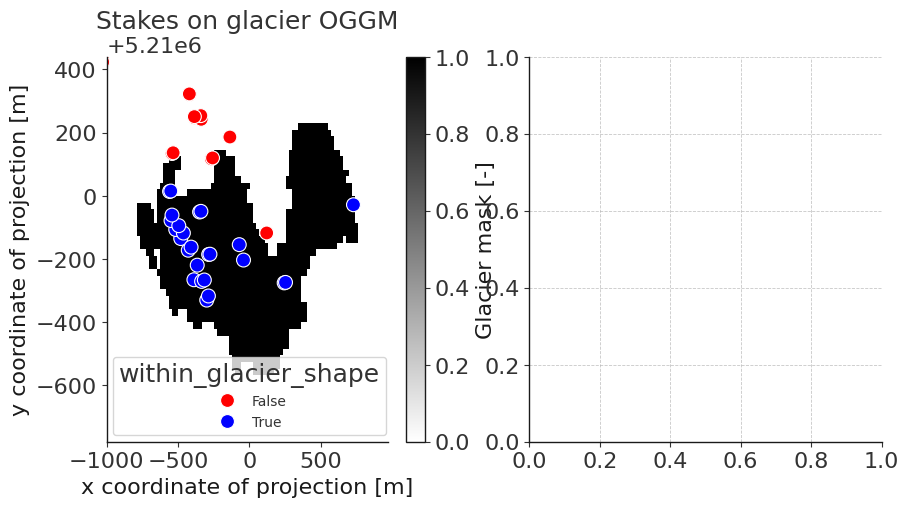

In [13]:
# Example:
glacierName = 'GOLDBERG K.'
# stakes
df_stakes = df_it_at_stakes_dropped_stakes_topo.copy()
df_stakes = df_stakes[(df_stakes['GLACIER'] == glacierName)]
RGIId = df_stakes.RGIId.unique()[0]
print(RGIId)
# open OGGM xr for glacier
# Get oggm data for that RGI grid
ds_oggm = xr.open_dataset(f'/home/mburlet/scratch/data/DATA_MB/DEV/OGGM/xr_grids/{RGIId}.zarr')

# Define the coordinate transformation
transf = pyproj.Transformer.from_proj(
    pyproj.CRS.from_user_input("EPSG:4326"),  # Input CRS (WGS84)
    pyproj.CRS.from_user_input(ds_oggm.pyproj_srs),  # Output CRS from dataset
    always_xy=True)

# Transform all coordinates in the group
lon, lat = df_stakes["POINT_LON"].values, df_stakes["POINT_LAT"].values
x_stake, y_stake = transf.transform(lon, lat)
df_stakes['x'] = x_stake
df_stakes['y'] = y_stake

# plot stakes
plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
ds_oggm.glacier_mask.plot(cmap='binary', ax=ax)
sns.scatterplot(df_stakes,
                x='x',
                y='y',
                hue='within_glacier_shape',
                ax=ax,
                palette=['r', 'b'])
ax.set_title('Stakes on glacier OGGM')

ax = plt.subplot(122)
path_SGI_topo = '/home/mburlet/scratch/data/DATA_MB/DEV/GLAMOS/topo/SGI2020/'
sgi_grid = xr.open_dataset(path_SGI_topo +
                           f'xr_masked_grids/{glacierName}.zarr')
sgi_grid.glacier_mask.plot(cmap='binary', ax=ax)
sns.scatterplot(df_stakes,
                x='POINT_LON',
                y='POINT_LAT',
                hue='within_glacier_shape',
                ax=ax,
                palette=['r', 'b'])
ax.set_title('Stakes on glacier')

In [14]:
# restrict to within glacier shape
df_it_at_stakes_dropped_stakes_topo = df_it_at_stakes_dropped_stakes_topo[df_it_at_stakes_dropped_stakes_topo['within_glacier_shape']]
df_it_at_stakes_dropped_stakes_topo = df_it_at_stakes_dropped_stakes_topo.drop(columns=['within_glacier_shape'])

print('Number of winter, summer and annual samples:', len(df_it_at_stakes_dropped_stakes_topo))
print('Number of annual samples:',
      len(df_it_at_stakes_dropped_stakes_topo[df_it_at_stakes_dropped_stakes_topo.PERIOD == 'annual']))
print('Number of winter samples:',
      len(df_it_at_stakes_dropped_stakes_topo[df_it_at_stakes_dropped_stakes_topo.PERIOD == 'winter']))
print('Number of summer samples:',
      len(df_it_at_stakes_dropped_stakes_topo[df_it_at_stakes_dropped_stakes_topo.PERIOD == 'summer']))
# Unique glaciers, sorted
glacier_list = sorted(df_it_at_stakes_dropped_stakes_topo.GLACIER.unique())
print(f"Number of glaciers: {len(glacier_list)}")
print(f"Glaciers: {glacier_list}")

Number of winter, summer and annual samples: 5086
Number of annual samples: 2872
Number of winter samples: 1548
Number of summer samples: 666
Number of glaciers: 24
Glaciers: ['CAMPO SETT.', 'CARESER', 'CARESER CENTRALE', 'CARESER OCCIDENTALE', 'CARESER ORIENTALE', 'CIARDONEY', 'FONTANA BIANCA / WEISSBRUNNF.', 'GOLDBERG K.', 'GRAND ETRET', 'HALLSTAETTER G.', 'HINTEREIS F.', 'JAMTAL F.', 'KESSELWAND F.', 'KLEINFLEISS K.', 'LUNGA (VEDRETTA) / LANGENF.', 'LUPO', 'MALAVALLE (VEDR. DI) / UEBELTALF.', 'OE. WURTEN K.', 'PENDENTE (VEDR.) / HANGENDERF.', 'RIES OCC. (VEDR. DI) / RIESERF. WESTL.', 'SURETTA MERIDIONALE', 'VENEDIGER K.', 'VERNAGT F.', 'ZETTALUNITZ/MULLWITZ K.']


In [15]:
display(df_it_at_stakes_dropped_stakes_topo.head(2))

df_it_at_stakes_dropped_stakes_topo.to_csv('/home/mburlet/scratch/data/DATA_MB/WGMS/DOI-WGMS-FoG-2025-02b/csv/IT_AT_wgms_dataset_all_oggm.csv', index=False)

,POINT_ID,POINT_LAT,POINT_LON,POINT_ELEVATION,FROM_DATE,TO_DATE,POINT_BALANCE,GLACIER,PERIOD,RGIId,YEAR,aspect,slope,topo,hugonnet_dhdt,consensus_ice_thickness
0,GOLDBERG K._2020_43346_AT,47.041127,12.965073,2700.0,20190920,20200922,0.276,GOLDBERG K.,annual,RGI60-11.00289,2020,48.343734,8.445758,2697.0,-1.065098,48.199932
1,GOLDBERG K._2020_43383_AT,47.043262,12.979787,2410.0,20190920,20200922,-1.278,GOLDBERG K.,annual,RGI60-11.00289,2020,349.177712,16.786407,2421.0,-1.196566,12.570357


##  Assemble measurement periods:
### Annual measurements: 
Process annual measurements and put all stakes into one csv file

In [5]:
# Display the first two rows
df_annual_raw = process_annual_stake_data(path_PMB_GLAMOS_csv_a)
df_annual_raw.head(2)

,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD,...,mb_raw,density,density_quality,measurement_quality,measurement_type,mb_error,reading_error,density_error,error_evaluation_method,source
0,2003,01,oberaar,20021006,20031011,46.538806,8.233237,2389.812633,-6174,annual,...,-686,900,1,1,1,102,45,92,0,hm
1,2003,02,oberaar,20021006,20031011,46.536611,8.225514,2499.825727,-5310,annual,...,-590,900,1,1,1,91,45,79,0,hm


### Winter measurements:
For each point in annual meas., take winter meas that was taken closest:

In [6]:
process_winter_stake_data(df_annual_raw, path_PMB_GLAMOS_csv_w,
                          path_PMB_GLAMOS_csv_w_clean)

### Assemble both periods:

In [7]:
df_all_raw = assemble_all_stake_data(df_annual_raw,
                                     path_PMB_GLAMOS_csv_w_clean,
                                     path_PMB_GLAMOS_csv)

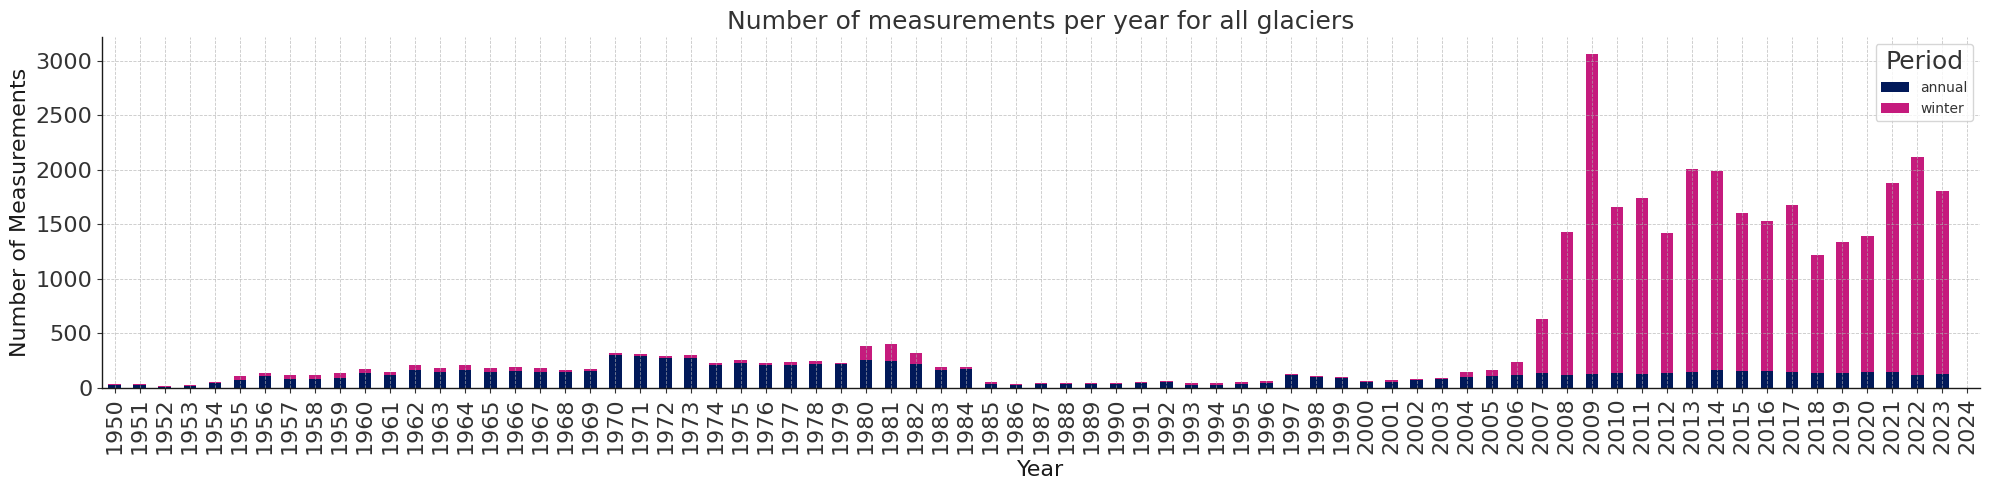

In [8]:
# Plot: Number of measurements per year
df_measurements_per_year = df_all_raw.groupby(['YEAR',
                                               'PERIOD']).size().unstack()
df_measurements_per_year.plot(kind='bar',
                              stacked=True,
                              figsize=(20, 5),
                              color=[color_1, color_2])
plt.title('Number of measurements per year for all glaciers')
plt.ylabel('Number of Measurements')
plt.xlabel('Year')
plt.legend(title='Period')
plt.tight_layout()
plt.show()

## Add RGIs Ids:

For each PMB measurement, we want to add the RGI ID (v6) of the shapefile it belongs to. 

In [9]:
glacier_outline_fname = '/home/mburlet/scratch/data/DATA_MB/DEV/GLAMOS/RGI/nsidc0770_11.rgi60.CentralEurope/11_rgi60_CentralEurope.shp'
df_pmb = add_rgi_ids_to_df(df_all_raw, glacier_outline_fname)

rgiids6 = df_pmb[['GLACIER', 'RGIId']].drop_duplicates()
if check_multiple_rgi_ids(rgiids6):
    print(
        "-- Alert: The following glaciers have more than one RGIId. Cleaning up."
    )
    df_pmb_clean = clean_rgi_ids(df_pmb.copy())
    df_pmb_clean.reset_index(drop=True, inplace=True)

    rgiids6_clean = df_pmb_clean[['GLACIER', 'RGIId']].drop_duplicates()
    if check_multiple_rgi_ids(rgiids6_clean):
        print("-- Error: Some glaciers still have more than one RGIId.")
    else:
        print("-- All glaciers are correctly associated with a single RGIId.")
else:
    print("-- All glaciers are correctly associated with a single RGIId.")
    df_pmb_clean = df_pmb

Finding closest RGIId:   0%|          | 0/2620 [00:00<?, ?it/s]

-- Alert: The following glaciers have more than one RGIId. Cleaning up.
-- All glaciers are correctly associated with a single RGIId.


## Cut from 1951:

Number of winter and annual samples: 36453
Number of annual samples: 8985
Number of winter samples: 27468


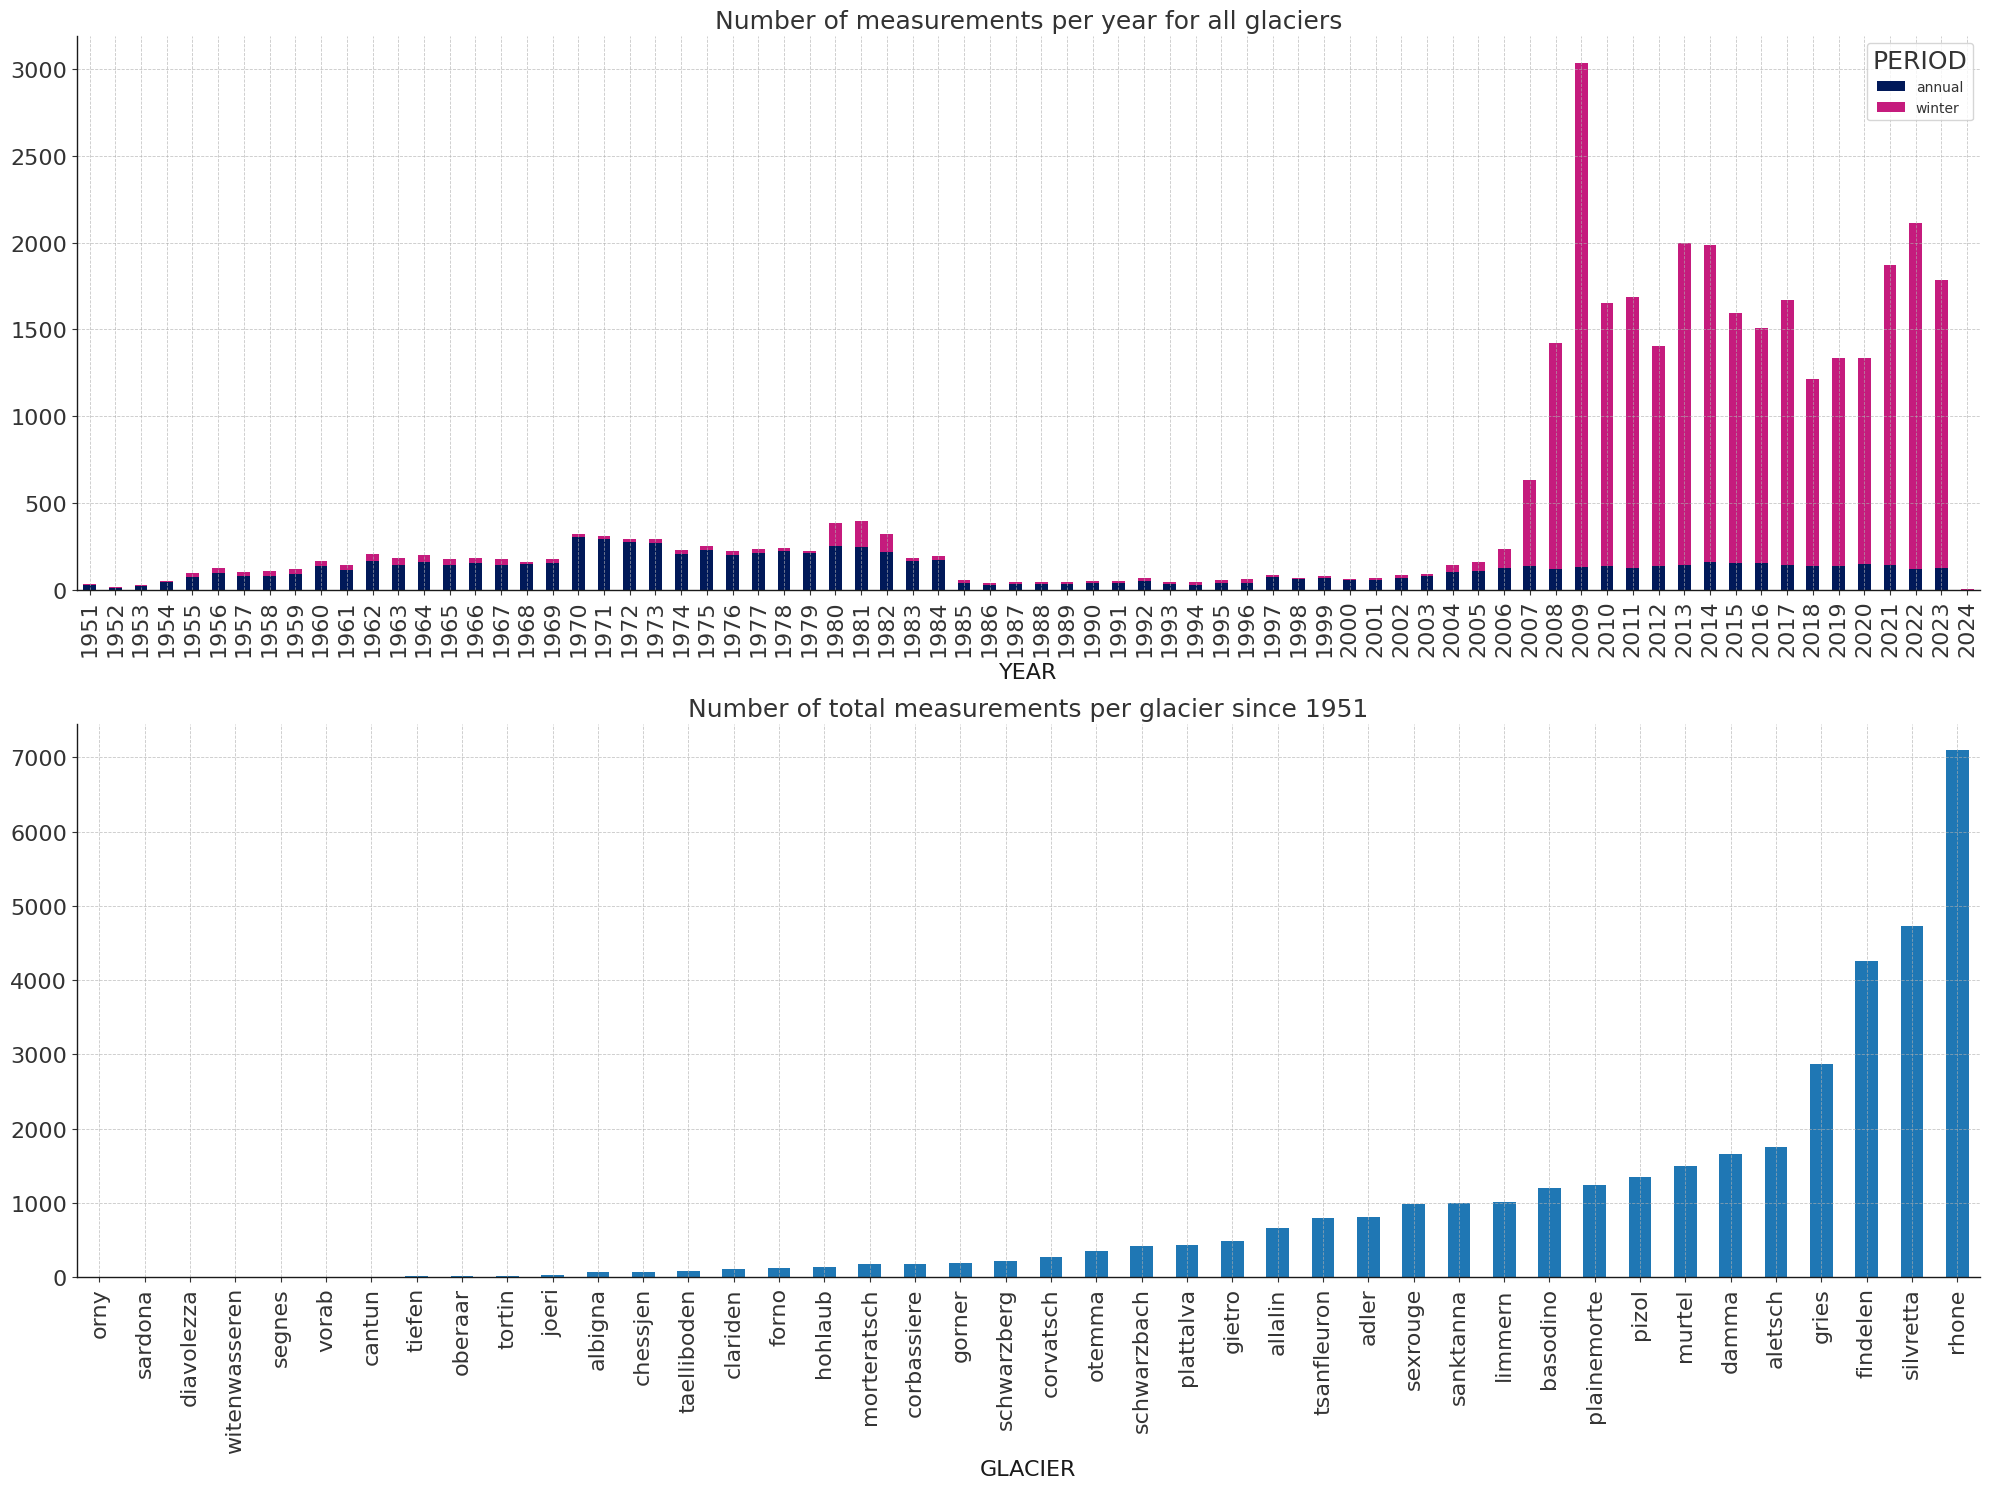

In [10]:
# Filter to start of MS data (1951) or ERA5-Land data (1950):
df_pmb_50s = df_pmb_clean[df_pmb_clean.YEAR > 1950].sort_values(
    by=['GLACIER', 'YEAR'], ascending=[True, True])

# Change from mm w.e. to m w.e.
df_pmb_50s['POINT_BALANCE'] = df_pmb_50s['POINT_BALANCE'] / 1000

# merge ClaridenL and ClaridenU into one glacier:
df_pmb_50s.loc[df_pmb_50s.GLACIER == 'claridenU', 'GLACIER'] = 'clariden'
df_pmb_50s.loc[df_pmb_50s.GLACIER == 'claridenL', 'GLACIER'] = 'clariden'

print('Number of winter and annual samples:', len(df_pmb_50s))
print('Number of annual samples:',
      len(df_pmb_50s[df_pmb_50s.PERIOD == 'annual']))
print('Number of winter samples:',
      len(df_pmb_50s[df_pmb_50s.PERIOD == 'winter']))

# Number of measurements per year:
fig, axs = plt.subplots(2, 1, figsize=(20, 15))
ax = axs.flatten()[0]
df_pmb_50s.groupby(['YEAR',
                    'PERIOD']).size().unstack().plot(kind='bar',
                                                     stacked=True,
                                                     color=[color_1, color_2],
                                                     ax=ax)
ax.set_title('Number of measurements per year for all glaciers')

ax = axs.flatten()[1]
num_gl = df_pmb_50s.groupby(['GLACIER']).size().sort_values()
num_gl.plot(kind='bar', ax=ax)
ax.set_title('Number of total measurements per glacier since 1951')
plt.tight_layout()

### Merge stakes that are close: 
Especially with winter probes, a lot of measurements were done at the same place in the raw data and this leads to noise. We merge the stakes that are very close and keep the mean of the measurement.


In [11]:
df_pmb_50s_clean = pd.DataFrame()
for gl in tqdm(df_pmb_50s.GLACIER.unique(), desc='Merging stakes'):
    print(f'-- {gl.capitalize()}:')
    df_gl = df_pmb_50s[df_pmb_50s.GLACIER == gl]
    df_gl_cleaned = remove_close_points(df_gl)
    df_pmb_50s_clean = pd.concat([df_pmb_50s_clean, df_gl_cleaned])

df_pmb_50s_clean.drop(['x', 'y'], axis=1, inplace=True)

# Save intermediate output
print('Saving intermediate output df_pmb_50s.csv to {path_PMB_GLAMOS_csv}')
df_pmb_50s_clean.to_csv(os.path.join(path_PMB_GLAMOS_csv, 'df_pmb_50s.csv'),
                        index=False)
df_pmb_50s_clean[['GLACIER', 'POINT_ID', 'POINT_LAT', 'POINT_LON',
                  'PERIOD']].to_csv(os.path.join(path_PMB_GLAMOS_csv,
                                                 'coordinate_50s.csv'),
                                    index=False)

Merging stakes:   0%|          | 0/42 [00:00<?, ?it/s]

-- Adler:


2025-04-23 07:09:44,109 - INFO - --- Number of points dropped: 5


-- Albigna:


2025-04-23 07:09:44,522 - INFO - --- Number of points dropped: 1


-- Aletsch:


2025-04-23 07:09:48,037 - INFO - --- Number of points dropped: 233


-- Allalin:


2025-04-23 07:09:51,509 - INFO - --- Number of points dropped: 68


-- Basodino:


2025-04-23 07:09:53,698 - INFO - --- Number of points dropped: 6
2025-04-23 07:09:53,709 - INFO - --- Number of points dropped: 0


-- Cantun:
-- Chessjen:


2025-04-23 07:09:54,410 - INFO - --- Number of points dropped: 15


-- Clariden:


2025-04-23 07:09:55,079 - INFO - --- Number of points dropped: 0


-- Corbassiere:


2025-04-23 07:09:56,021 - INFO - --- Number of points dropped: 1


-- Corvatsch:


2025-04-23 07:09:56,610 - INFO - --- Number of points dropped: 0


-- Damma:


2025-04-23 07:09:56,820 - INFO - --- Number of points dropped: 200
2025-04-23 07:09:56,827 - INFO - --- Number of points dropped: 0


-- Diavolezza:
-- Findelen:


2025-04-23 07:09:58,031 - INFO - --- Number of points dropped: 59


-- Forno:


2025-04-23 07:09:58,444 - INFO - --- Number of points dropped: 0


-- Gietro:


2025-04-23 07:10:00,428 - INFO - --- Number of points dropped: 0


-- Gorner:


2025-04-23 07:10:00,709 - INFO - --- Number of points dropped: 4


-- Gries:


2025-04-23 07:10:04,034 - INFO - --- Number of points dropped: 39


-- Hohlaub:


2025-04-23 07:10:05,607 - INFO - --- Number of points dropped: 2


-- Joeri:


2025-04-23 07:10:05,994 - INFO - --- Number of points dropped: 0


-- Limmern:


2025-04-23 07:10:07,846 - INFO - --- Number of points dropped: 16


-- Morteratsch:


2025-04-23 07:10:08,552 - INFO - --- Number of points dropped: 0


-- Murtel:


2025-04-23 07:10:09,285 - INFO - --- Number of points dropped: 29
2025-04-23 07:10:09,406 - INFO - --- Number of points dropped: 0
2025-04-23 07:10:09,412 - INFO - --- Number of points dropped: 0


-- Oberaar:
-- Orny:
-- Otemma:


2025-04-23 07:10:09,663 - INFO - --- Number of points dropped: 1


-- Pizol:


2025-04-23 07:10:10,769 - INFO - --- Number of points dropped: 121


-- Plainemorte:


2025-04-23 07:10:11,702 - INFO - --- Number of points dropped: 11


-- Plattalva:


2025-04-23 07:10:13,586 - INFO - --- Number of points dropped: 8


-- Rhone:


2025-04-23 07:10:15,076 - INFO - --- Number of points dropped: 221


-- Sanktanna:


2025-04-23 07:10:15,911 - INFO - --- Number of points dropped: 27
2025-04-23 07:10:15,919 - INFO - --- Number of points dropped: 0


-- Sardona:
-- Schwarzbach:


2025-04-23 07:10:16,487 - INFO - --- Number of points dropped: 44


-- Schwarzberg:


2025-04-23 07:10:18,146 - INFO - --- Number of points dropped: 3
2025-04-23 07:10:18,262 - INFO - --- Number of points dropped: 0


-- Segnes:
-- Sexrouge:


2025-04-23 07:10:19,061 - INFO - --- Number of points dropped: 17


-- Silvretta:


2025-04-23 07:10:21,968 - INFO - --- Number of points dropped: 34


-- Taelliboden:


2025-04-23 07:10:23,262 - INFO - --- Number of points dropped: 0
2025-04-23 07:10:23,412 - INFO - --- Number of points dropped: 0


-- Tiefen:
-- Tortin:


2025-04-23 07:10:23,667 - INFO - --- Number of points dropped: 0


-- Tsanfleuron:


2025-04-23 07:10:24,270 - INFO - --- Number of points dropped: 18
2025-04-23 07:10:24,385 - INFO - --- Number of points dropped: 0
2025-04-23 07:10:24,428 - INFO - --- Number of points dropped: 0


-- Vorab:
-- Witenwasseren:
Saving intermediate output df_pmb_50s.csv to {path_PMB_GLAMOS_csv}


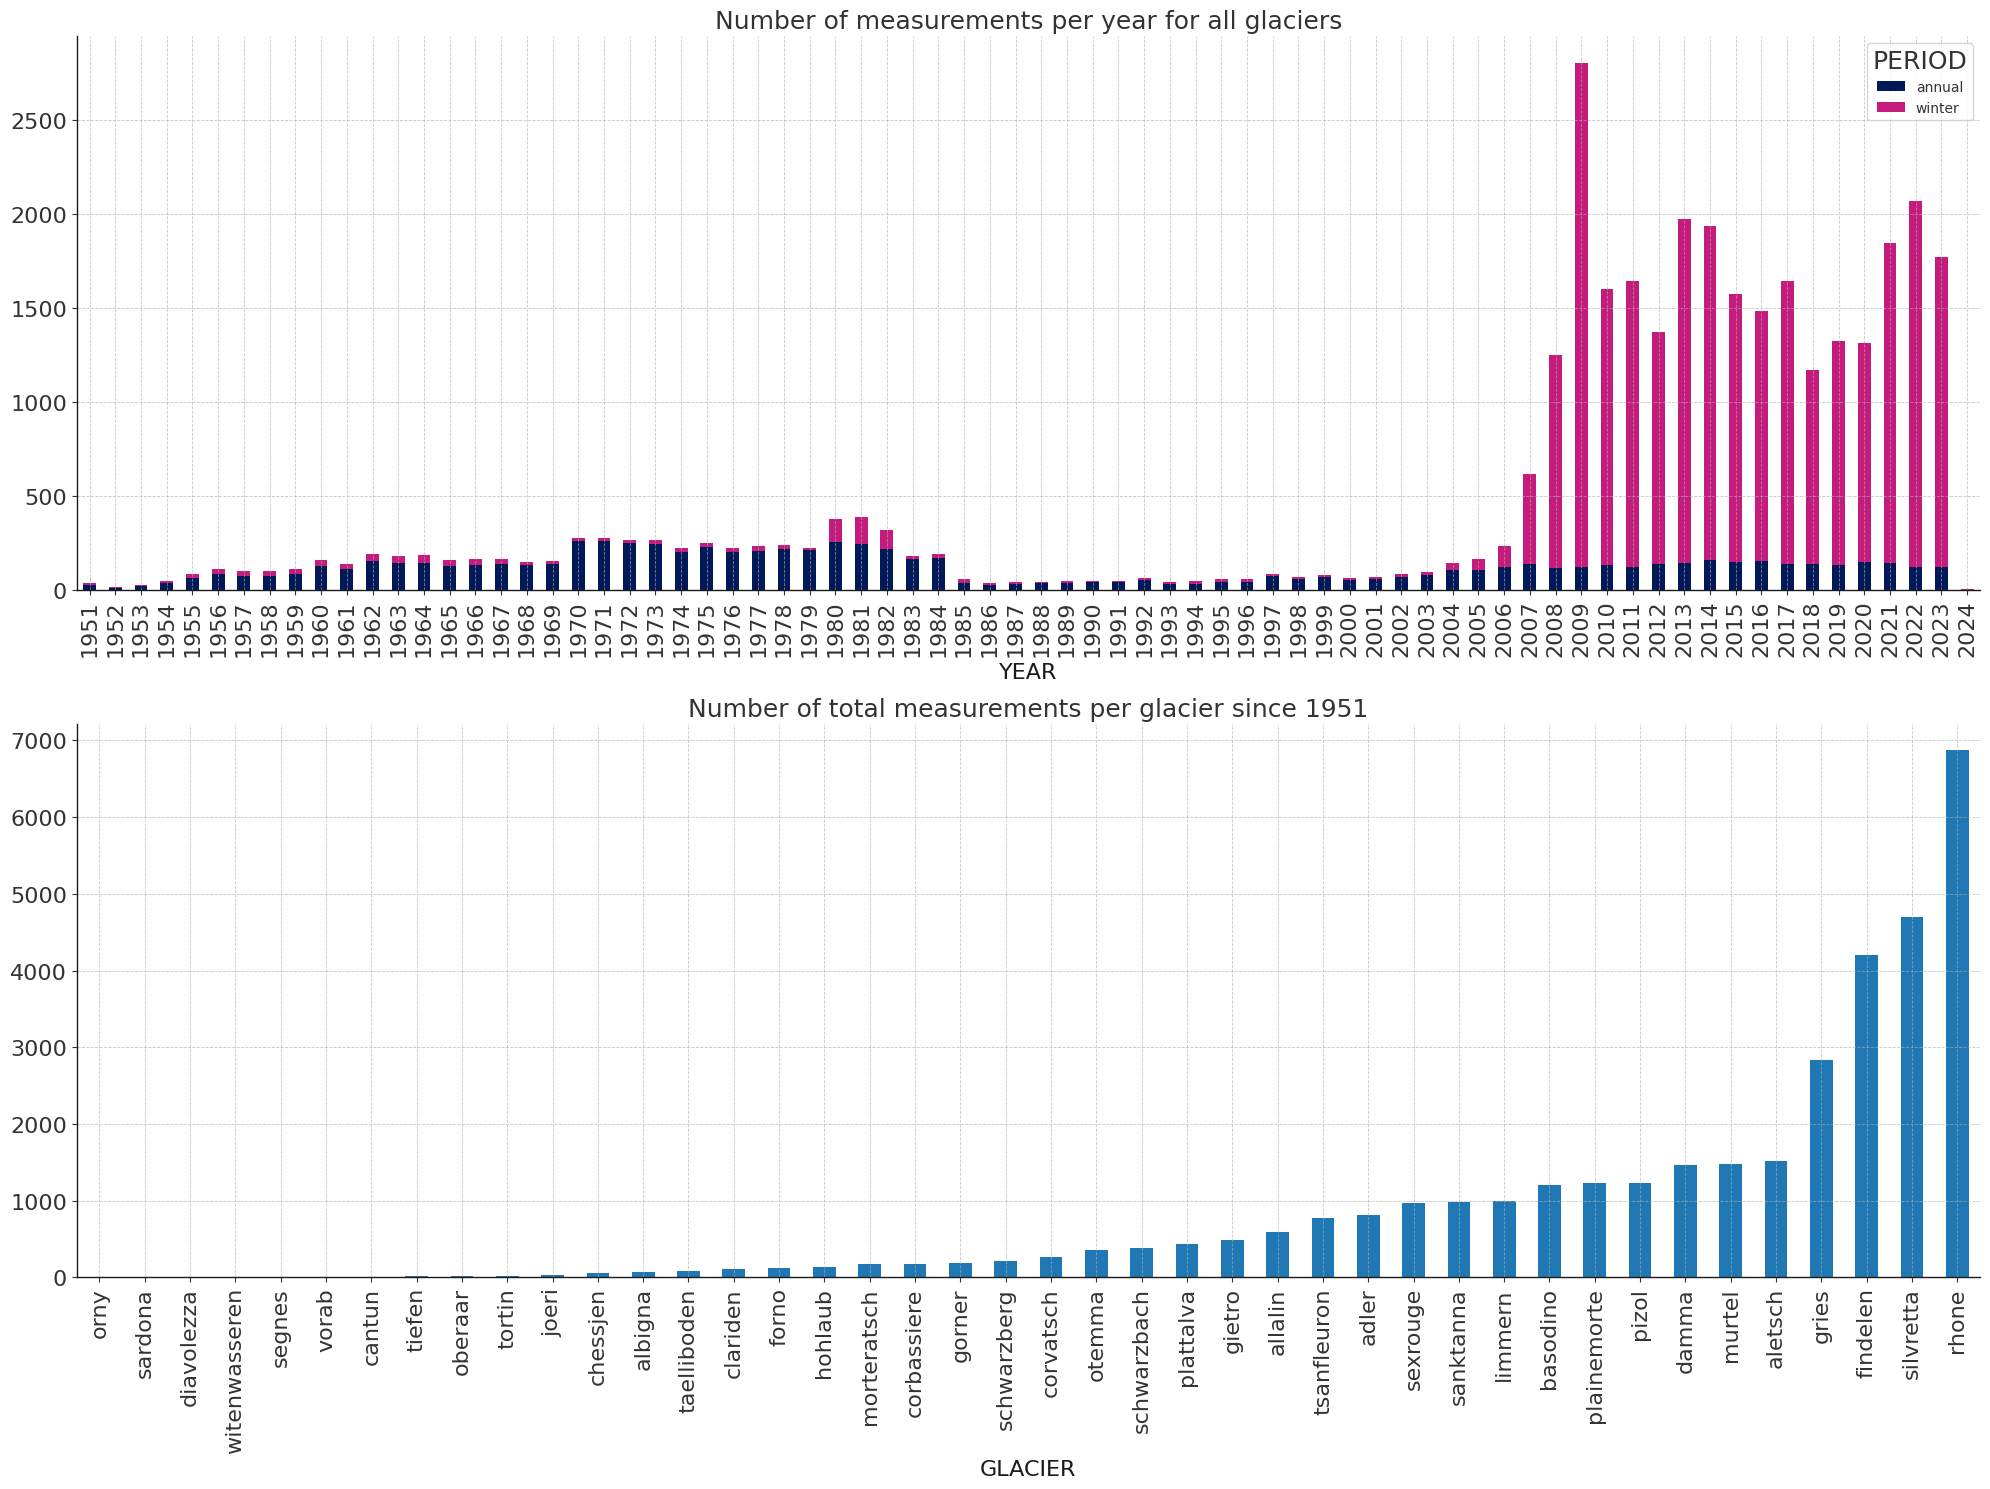

In [12]:
# Number of measurements per year:
fig, axs = plt.subplots(2, 1, figsize=(20, 15))
ax = axs.flatten()[0]
df_pmb_50s_clean.groupby(['YEAR', 'PERIOD'
                          ]).size().unstack().plot(kind='bar',
                                                   stacked=True,
                                                   color=[color_1, color_2],
                                                   ax=ax)
ax.set_title('Number of measurements per year for all glaciers')

ax = axs.flatten()[1]
num_gl = df_pmb_50s_clean.groupby(['GLACIER']).size().sort_values()
num_gl.plot(kind='bar', ax=ax)
ax.set_title('Number of total measurements per glacier since 1951')
plt.tight_layout()

In [13]:
glacier_list = list(df_pmb_50s_clean.GLACIER.unique())
print('Number of glaciers:', len(glacier_list))
glacier_list.sort()
glacier_list

Number of glaciers: 42


['adler',
 'albigna',
 'aletsch',
 'allalin',
 'basodino',
 'cantun',
 'chessjen',
 'clariden',
 'corbassiere',
 'corvatsch',
 'damma',
 'diavolezza',
 'findelen',
 'forno',
 'gietro',
 'gorner',
 'gries',
 'hohlaub',
 'joeri',
 'limmern',
 'morteratsch',
 'murtel',
 'oberaar',
 'orny',
 'otemma',
 'pizol',
 'plainemorte',
 'plattalva',
 'rhone',
 'sanktanna',
 'sardona',
 'schwarzbach',
 'schwarzberg',
 'segnes',
 'sexrouge',
 'silvretta',
 'taelliboden',
 'tiefen',
 'tortin',
 'tsanfleuron',
 'vorab',
 'witenwasseren']

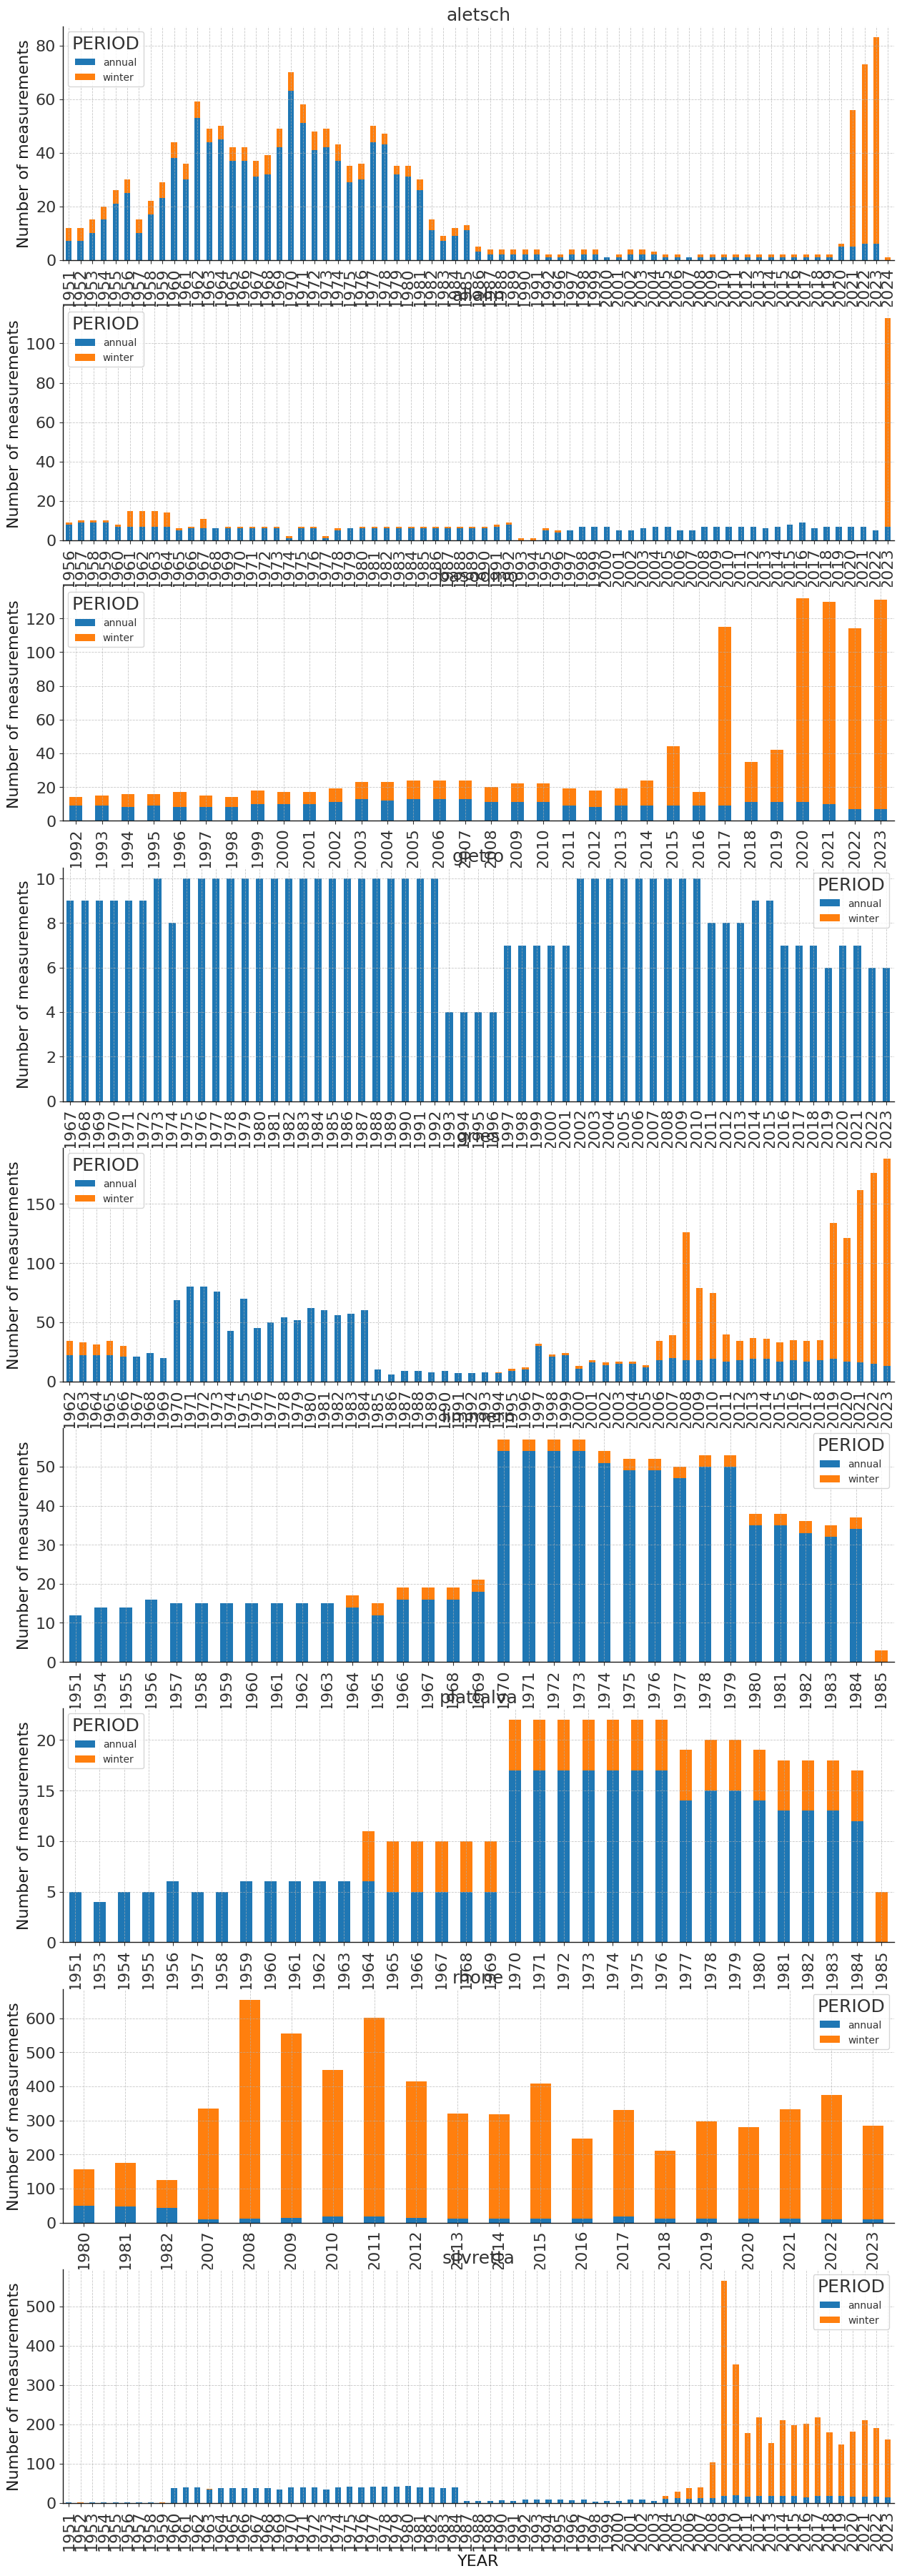

In [14]:
# Number of measurements per glacier per year:
num_gl_yr = df_pmb_50s_clean.groupby(['GLACIER', 'YEAR', 'PERIOD'
                                      ]).size().unstack().reset_index()

num_gl_annual = df_pmb_50s_clean[df_pmb_50s_clean.PERIOD == 'annual'].groupby(
    ['GLACIER']).size().sort_values()

# Plot one glacier per column:
big_gl = num_gl_annual[num_gl_annual > 250].index.sort_values()
num_glaciers = len(big_gl)
fig, ax = plt.subplots(num_glaciers, 1, figsize=(15, 5 * num_glaciers))
for i, gl in enumerate(big_gl):
    num_gl_yr[num_gl_yr.GLACIER == gl].plot(x='YEAR',
                                            kind='bar',
                                            stacked=True,
                                            ax=ax[i],
                                            title=gl)
    ax[i].set_ylabel('Number of measurements')
    ax[i].set_title

In [15]:
print('Number of winter and annual samples:', len(df_pmb_50s_clean))
print('Number of annual samples:',
      len(df_pmb_50s_clean[df_pmb_50s_clean.PERIOD == 'annual']))
print('Number of winter samples:',
      len(df_pmb_50s_clean[df_pmb_50s_clean.PERIOD == 'winter']))
# Unique glaciers, sorted
glacier_list = sorted(df_pmb_50s_clean.GLACIER.unique())
print(f"Number of glaciers: {len(glacier_list)}")
print(f"Glaciers: {glacier_list}")

Number of winter and annual samples: 35270
Number of annual samples: 8636
Number of winter samples: 26634
Number of glaciers: 42
Glaciers: ['adler', 'albigna', 'aletsch', 'allalin', 'basodino', 'cantun', 'chessjen', 'clariden', 'corbassiere', 'corvatsch', 'damma', 'diavolezza', 'findelen', 'forno', 'gietro', 'gorner', 'gries', 'hohlaub', 'joeri', 'limmern', 'morteratsch', 'murtel', 'oberaar', 'orny', 'otemma', 'pizol', 'plainemorte', 'plattalva', 'rhone', 'sanktanna', 'sardona', 'schwarzbach', 'schwarzberg', 'segnes', 'sexrouge', 'silvretta', 'taelliboden', 'tiefen', 'tortin', 'tsanfleuron', 'vorab', 'witenwasseren']


## Add topographical information from OGGM & SGI:

### OGGM data:

In [16]:
# initialize OGGM glacier directories
df_pmb_50s_clean = pd.read_csv(path_PMB_GLAMOS_csv + 'df_pmb_50s.csv')
gdirs, rgidf = initialize_oggm_glacier_directories(
    working_dir='/home/mburlet/scratch/data/DATA_MB/DEV/OGGM/',
    rgi_region="11",
    rgi_version="6",
    base_url=
    "https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5_w_data/",
    log_level='WARNING',
    task_list=None,
)
unique_rgis = df_pmb_50s_clean['RGIId'].unique()

export_oggm_grids(gdirs, subset_rgis=None, output_path=path_OGGM_xrgrids)

df_pmb_topo = merge_pmb_with_oggm_data(df_pmb=df_pmb_50s_clean,
                                       gdirs=gdirs,
                                       rgi_region="11",
                                       rgi_version="6")

2025-04-23 07:11:44: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-04-23 07:11:44: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-04-23 07:11:44: oggm.cfg: Multiprocessing: using all available processors (N=32)
2025-04-23 07:11:44: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2025-04-23 07:11:44: oggm.cfg: Multiprocessing switched ON after user settings.
2025-04-23 07:11:44: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2025-04-23 07:11:45: oggm.workflow: init_glacier_directories from prepro level 3 on 3927 glaciers.
2025-04-23 07:11:45: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 3927 glaciers
2025-04-23 07:12:02: oggm.workflow: Execute entity tasks [gridded_attributes] on 3927 glaciers


RGI60-11.01450


ValueError: Could not interpret value `within_glacier_shape` for `hue`. An entry with this name does not appear in `data`.

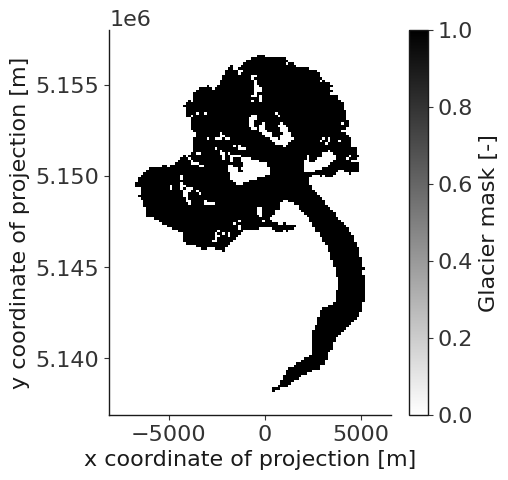

In [24]:
# Example:
glacierName = 'aletsch'
# stakes
df_stakes = df_pmb_topo.copy()
df_stakes = df_stakes[(df_stakes['GLACIER'] == glacierName)]
RGIId = df_stakes.RGIId.unique()[0]
print(RGIId)
# open OGGM xr for glacier
# Get oggm data for that RGI grid
ds_oggm = xr.open_dataset(f'/home/mburlet/scratch/data/DATA_MB/DEV/OGGM/xr_grids/{RGIId}.zarr')

# Define the coordinate transformation
transf = pyproj.Transformer.from_proj(
    pyproj.CRS.from_user_input("EPSG:4326"),  # Input CRS (WGS84)
    pyproj.CRS.from_user_input(ds_oggm.pyproj_srs),  # Output CRS from dataset
    always_xy=True)

# Transform all coordinates in the group
lon, lat = df_stakes["POINT_LON"].values, df_stakes["POINT_LAT"].values
x_stake, y_stake = transf.transform(lon, lat)
df_stakes['x'] = x_stake
df_stakes['y'] = y_stake

# plot stakes
plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
ds_oggm.glacier_mask.plot(cmap='binary', ax=ax)
sns.scatterplot(df_stakes,
                x='x',
                y='y',
                hue='within_glacier_shape',
                ax=ax,
                palette=['r', 'b'])
ax.set_title('Stakes on glacier OGGM')

ax = plt.subplot(122)
path_SGI_topo = '/home/mburlet/scratch/data/DATA_MB/DEV/GLAMOS/topo/SGI2020/'
sgi_grid = xr.open_dataset(path_SGI_topo +
                           f'xr_masked_grids/{glacierName}.zarr')
sgi_grid.glacier_mask.plot(cmap='binary', ax=ax)
sns.scatterplot(df_stakes,
                x='POINT_LON',
                y='POINT_LAT',
                hue='within_glacier_shape',
                ax=ax,
                palette=['r', 'b'])
ax.set_title('Stakes on glacier')

In [21]:
# restrict to within glacier shape
df_pmb_topo = df_pmb_topo[df_pmb_topo['within_glacier_shape']]
df_pmb_topo = df_pmb_topo.drop(columns=['within_glacier_shape'])

print('Number of winter and annual samples:', len(df_pmb_topo))
print('Number of annual samples:',
      len(df_pmb_topo[df_pmb_topo.PERIOD == 'annual']))
print('Number of winter samples:',
      len(df_pmb_topo[df_pmb_topo.PERIOD == 'winter']))
# Unique glaciers, sorted
glacier_list = sorted(df_pmb_topo.GLACIER.unique())
print(f"Number of glaciers: {len(glacier_list)}")
print(f"Glaciers: {glacier_list}")

Number of winter and annual samples: 32870
Number of annual samples: 7678
Number of winter samples: 25192
Number of glaciers: 41
Glaciers: ['adler', 'albigna', 'aletsch', 'allalin', 'basodino', 'cantun', 'chessjen', 'clariden', 'corbassiere', 'corvatsch', 'damma', 'findelen', 'forno', 'gietro', 'gorner', 'gries', 'hohlaub', 'joeri', 'limmern', 'morteratsch', 'murtel', 'oberaar', 'orny', 'otemma', 'pizol', 'plainemorte', 'plattalva', 'rhone', 'sanktanna', 'sardona', 'schwarzbach', 'schwarzberg', 'segnes', 'sexrouge', 'silvretta', 'taelliboden', 'tiefen', 'tortin', 'tsanfleuron', 'vorab', 'witenwasseren']


### SGI data:

In [26]:
# First create the masked topographical arrays per glacier:
glacier_list = sorted(df_pmb_topo.GLACIER.unique())
create_sgi_topo_masks(glacier_list,
                      type='glacier_name',
                      path_save=os.path.join(path_SGI_topo,
                                             'xr_masked_grids/'))

Processing glaciers:   0%|          | 0/41 [00:00<?, ?it/s]

Saved adler dataset to /home/mburlet/scratch/data/DATA_MB/DEV/GLAMOS/topo/SGI2020/xr_masked_grids/adler.zarr
Saved albigna dataset to /home/mburlet/scratch/data/DATA_MB/DEV/GLAMOS/topo/SGI2020/xr_masked_grids/albigna.zarr
Saved aletsch dataset to /home/mburlet/scratch/data/DATA_MB/DEV/GLAMOS/topo/SGI2020/xr_masked_grids/aletsch.zarr
Saved allalin dataset to /home/mburlet/scratch/data/DATA_MB/DEV/GLAMOS/topo/SGI2020/xr_masked_grids/allalin.zarr
Saved basodino dataset to /home/mburlet/scratch/data/DATA_MB/DEV/GLAMOS/topo/SGI2020/xr_masked_grids/basodino.zarr
Saved cantun dataset to /home/mburlet/scratch/data/DATA_MB/DEV/GLAMOS/topo/SGI2020/xr_masked_grids/cantun.zarr
Saved chessjen dataset to /home/mburlet/scratch/data/DATA_MB/DEV/GLAMOS/topo/SGI2020/xr_masked_grids/chessjen.zarr
Saved clariden dataset to /home/mburlet/scratch/data/DATA_MB/DEV/GLAMOS/topo/SGI2020/xr_masked_grids/clariden.zarr
Saved corbassiere dataset to /home/mburlet/scratch/data/DATA_MB/DEV/GLAMOS/topo/SGI2020/xr_maske

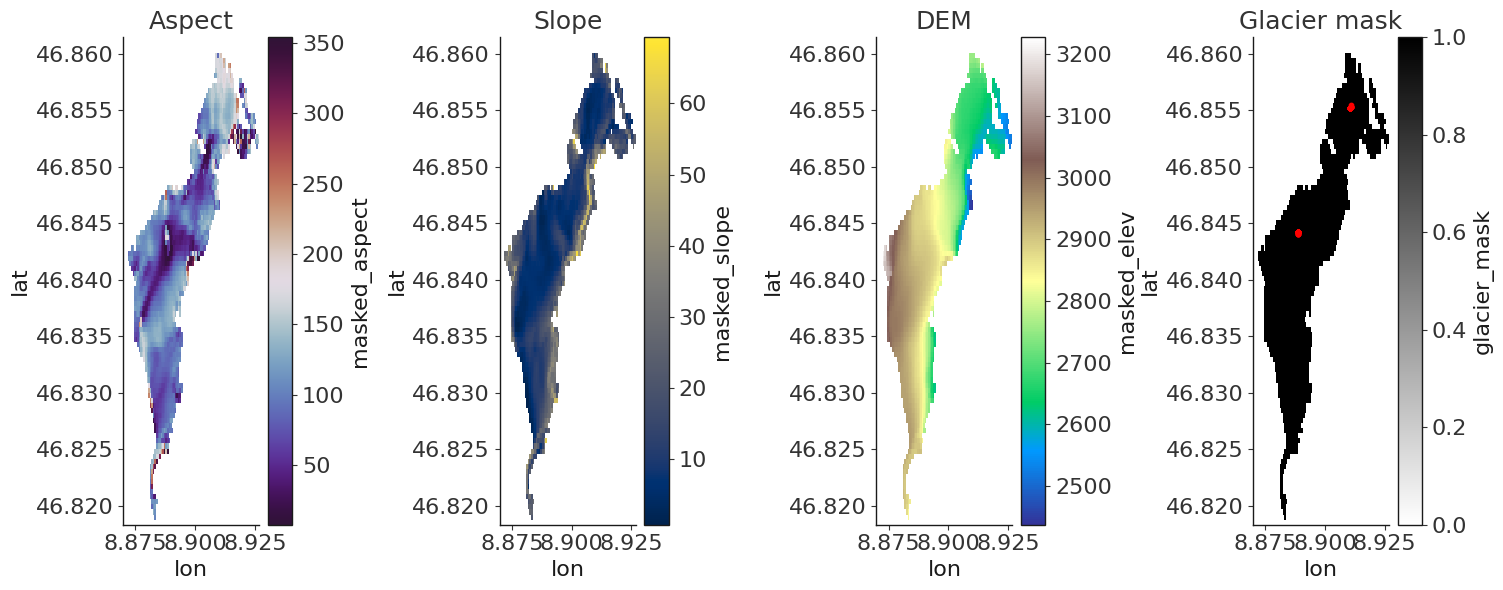

In [27]:
# Example
path_SGI_topo = '/home/mburlet/scratch/data/DATA_MB/DEV/GLAMOS/topo/SGI2020/'
i = 0
glacier_name = 'clariden'
df_pmb_gl = df_pmb_50s_clean[df_pmb_50s_clean.GLACIER == glacier_name]

stake_coordinates = df_pmb_gl[['POINT_LON', 'POINT_LAT']].values

# Open SGI grid:
ds_sgi = xr.open_dataset(path_SGI_topo + 'xr_masked_grids/' +
                         f'{glacier_name}.zarr')

# Plot the masked data
fig, axs = plt.subplots(1, 4, figsize=(15, 6))
ds_sgi.masked_aspect.plot(ax=axs[0], cmap='twilight_shifted')
ds_sgi.masked_slope.plot(ax=axs[1], cmap='cividis')
ds_sgi.masked_elev.plot(ax=axs[2], cmap='terrain')
ds_sgi.glacier_mask.plot(ax=axs[3], cmap='binary')
axs[3].scatter(stake_coordinates[:, 0], stake_coordinates[:, 1], c='r', s=10)
axs[0].set_title("Aspect")
axs[1].set_title("Slope")
axs[2].set_title("DEM")
axs[3].set_title("Glacier mask")
plt.tight_layout()

In [28]:
os.listdir(path_SGI_topo + 'xr_masked_grids/')

['tiefen.zarr',
 'limmern.zarr',
 'murtel.zarr',
 'basodino.zarr',
 'aletsch.zarr',
 'hohlaub.zarr',
 'allalin.zarr',
 'plattalva.zarr',
 'pizol.zarr',
 'damma.zarr',
 'silvretta.zarr',
 'gorner.zarr',
 'rhone.zarr',
 'findelen.zarr',
 'sardona.zarr',
 'chessjen.zarr',
 'albigna.zarr',
 'sexrouge.zarr',
 'schwarzbach.zarr',
 'vorab.zarr',
 'tortin.zarr',
 'joeri.zarr',
 'plainemorte.zarr',
 'corvatsch.zarr',
 'schwarzberg.zarr',
 'witenwasseren.zarr',
 'tsanfleuron.zarr',
 'otemma.zarr',
 'clariden.zarr',
 'sanktanna.zarr',
 'oberaar.zarr',
 'gietro.zarr',
 'cantun.zarr',
 'adler.zarr',
 'taelliboden.zarr',
 'morteratsch.zarr',
 'gries.zarr',
 'corbassiere.zarr',
 'forno.zarr']

In [29]:
path_masked_grids = os.path.join(path_SGI_topo, 'xr_masked_grids/')

# Merge PMB with SGI data
df_pmb_sgi = merge_pmb_with_sgi_data(
    df_pmb_topo,  # cleaned PMB DataFrame
    path_masked_grids,  # path to SGI grids
    voi=["masked_aspect", "masked_slope", "masked_elev"])

In [30]:
# Count and display the number of samples
print(f"Total number of winter and annual samples: {len(df_pmb_sgi)}")

# Count occurrences of 'PERIOD' values
period_counts = df_pmb_sgi['PERIOD'].value_counts()
print(f"Number of annual samples: {period_counts.get('annual', 0)}")
print(f"Number of winter samples: {period_counts.get('winter', 0)}")

# Unique years, sorted
unique_years = np.sort(df_pmb_sgi.YEAR.unique())
print(f"Unique years: {unique_years}")

# Unique glaciers, sorted
glacier_list = sorted(df_pmb_sgi.GLACIER.unique())
print(f"Number of glaciers: {len(glacier_list)}")
print(f"Glaciers: {glacier_list}")

Total number of winter and annual samples: 32861
Number of annual samples: 7669
Number of winter samples: 25192
Unique years: [1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964
 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978
 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992
 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006
 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020
 2021 2022 2023 2024]
Number of glaciers: 39
Glaciers: ['adler', 'albigna', 'aletsch', 'allalin', 'basodino', 'cantun', 'chessjen', 'clariden', 'corbassiere', 'corvatsch', 'damma', 'findelen', 'forno', 'gietro', 'gorner', 'gries', 'hohlaub', 'joeri', 'limmern', 'morteratsch', 'murtel', 'oberaar', 'otemma', 'pizol', 'plainemorte', 'plattalva', 'rhone', 'sanktanna', 'sardona', 'schwarzbach', 'schwarzberg', 'sexrouge', 'silvretta', 'taelliboden', 'tiefen', 'tortin', 'tsanfleuron', 'vorab', 'witenwasseren']


### Example:


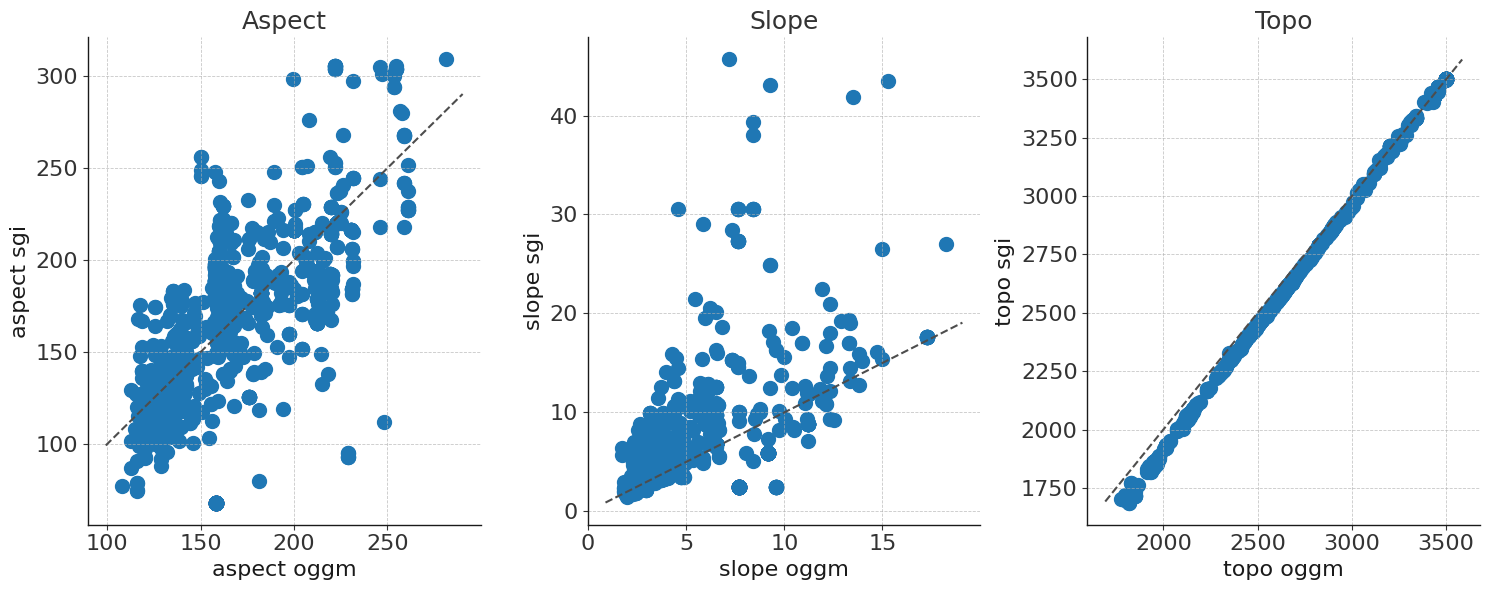

In [31]:
glacierName = 'aletsch'
df_pmb_gl = df_pmb_sgi[(df_pmb_sgi.GLACIER == glacierName)]

# Plot aspect and sgi aspect
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].scatter(df_pmb_gl.aspect, df_pmb_gl.aspect_sgi)
axs[0].set_xlabel('aspect oggm')
axs[0].set_ylabel('aspect sgi')
axs[0].set_title('Aspect')

axs[1].scatter(df_pmb_gl.slope, df_pmb_gl.slope_sgi)
axs[1].set_xlabel('slope oggm')
axs[1].set_ylabel('slope sgi')
axs[1].set_title('Slope')

# same for topo
axs[2].scatter(df_pmb_gl.topo, df_pmb_gl.topo_sgi)
axs[2].set_xlabel('topo oggm')
axs[2].set_ylabel('topo sgi')
axs[2].set_title('Topo')
# add 1:1 line
for ax in axs:
    ax.plot(ax.get_xlim(), ax.get_xlim(), ls="--", c=".3")

plt.tight_layout()

## Give new stake IDs:
Give new stake IDs with glacier name and then a number according to the elevation. This is because accross glaciers some stakes have the same ID which is not practical.

All POINT_IDs correctly contain their respective GLACIER names.
Number of winter and annual samples: 32861
Number of annual samples: 7669
Number of winter samples: 25192


Text(0.5, 0, 'Mass balance [m w.e.]')

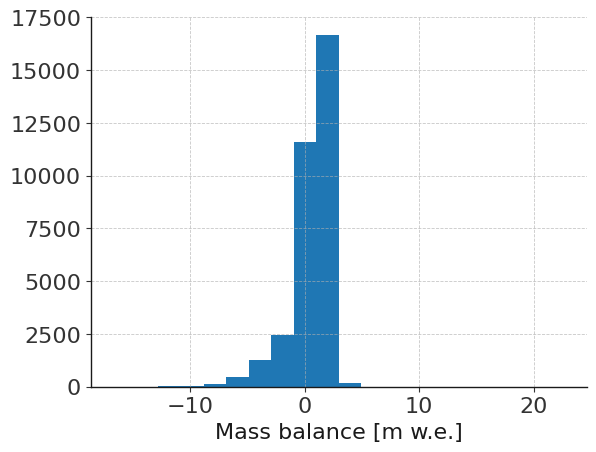

In [32]:
df_pmb_sgi = rename_stakes_by_elevation(df_pmb_sgi)

# Check the condition
check_point_ids_contain_glacier(df_pmb_sgi)

# Save to CSV
fname = 'CH_wgms_dataset_all.csv'
df_pmb_sgi.to_csv(os.path.join(path_PMB_GLAMOS_csv, fname), index=False)
log.info(f"-- Saved pmb & oggm dataset {fname} to: {path_PMB_GLAMOS_csv}")

print('Number of winter and annual samples:', len(df_pmb_sgi))
print('Number of annual samples:',
      len(df_pmb_sgi[df_pmb_sgi.PERIOD == 'annual']))
print('Number of winter samples:',
      len(df_pmb_sgi[df_pmb_sgi.PERIOD == 'winter']))

# Save to csv:
df_pmb_sgi.to_csv(path_PMB_GLAMOS_csv + f'CH_wgms_dataset_all.csv',
                  index=False)

# Histogram of mass balance
df_pmb_sgi['POINT_BALANCE'].hist(bins=20)
plt.xlabel('Mass balance [m w.e.]')

# Glacier wide MB:
Pre-processing of glacier wide SMB data from GLAMOS. Transform .dat files to .csv. 

In [ ]:
process_SMB_GLAMOS()

In [ ]:
# Obs: no fixed dates, but using observed periods.
# Example:
fileName = 'aletsch_obs.csv'
aletsch_csv = pd.read_csv(path_SMB_GLAMOS_csv + 'obs/' + fileName,
                          sep=',',
                          header=0,
                          encoding='latin-1')
aletsch_csv.head(2)

In [ ]:
# Fix: with fixed periods (hydrological year).
# # Example:
fileName = 'aletsch_fix.csv'
aletsch_csv = pd.read_csv(path_SMB_GLAMOS_csv + 'fix/' + fileName,
                          sep=',',
                          header=0,
                          encoding='latin-1')
aletsch_csv.head(2)

# Potential incoming clear sky solar radiation:

Pre-process glamos data of "potential incoming clear sky solar radiation (pcsr)" used as a topographical variable. One per day grid per glacier for one year only, depends on the glacier.

In [33]:
glDirect = np.sort(os.listdir(path_pcsr + 'raw/'))  # Glaciers with data

print('Number of glacier with clear sky radiation data:', len(glDirect))
print('Glaciers with clear sky radiation data:', glDirect)

process_pcsr()

FileNotFoundError: [Errno 2] No such file or directory: '/home/mburlet/scratch/data/DATA_MB/DEV/GLAMOS/topo/pcsr/raw/'

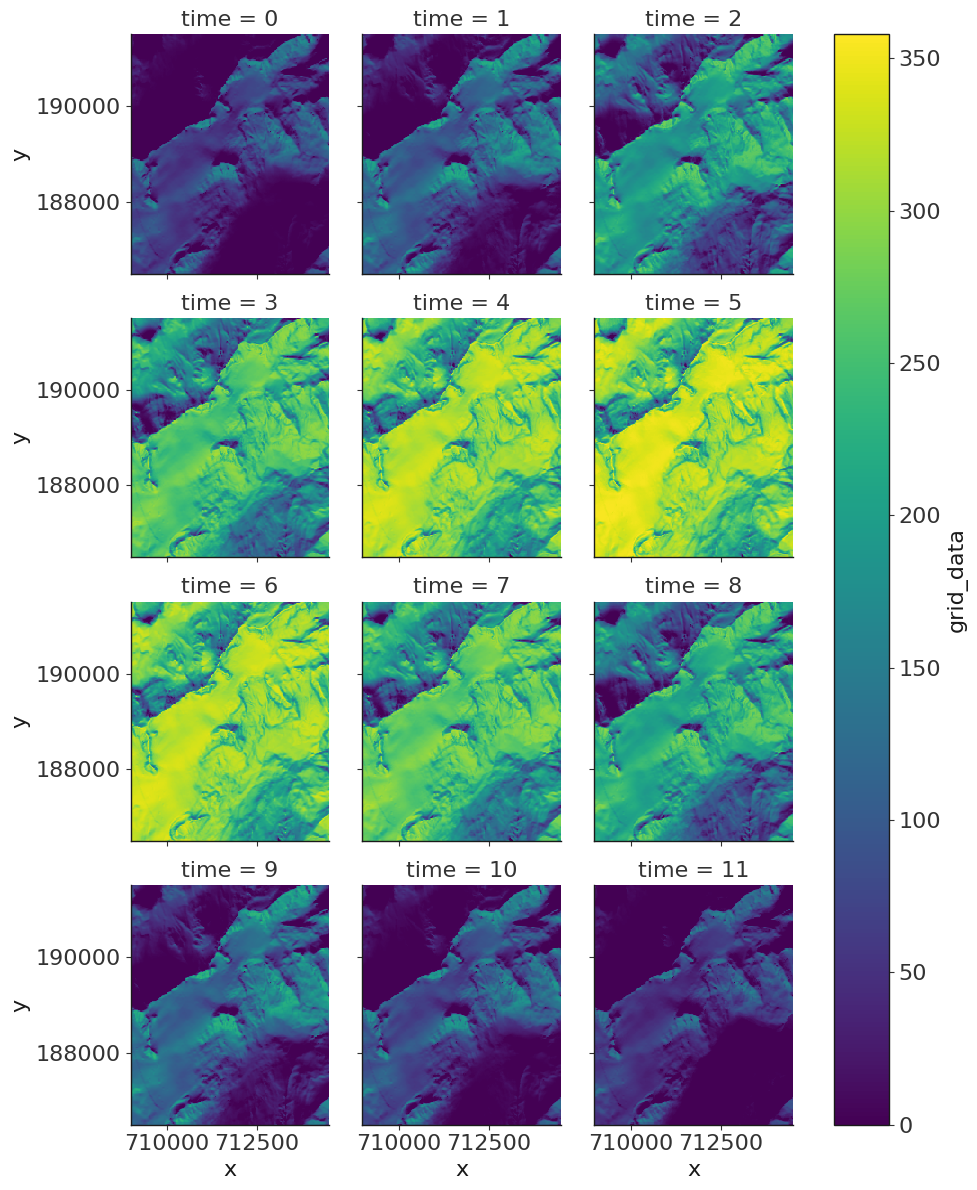

In [34]:
# read an plot one file
xr_file = xr.open_dataset(path_pcsr + 'zarr/' + 'xr_direct_clariden.zarr')
xr_file['grid_data'].plot(x='x', y='y', col='time', col_wrap=3)